In [1]:
pip install "openai==0.28.1" num2words matplotlib plotly scipy scikit-learn pandas tiktoken


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import csv
import re

In [3]:
import re

def process_text(input_text):
    # Remove anything inside and including square brackets
    input_text = re.sub(r'\[.*?\]', '', input_text)

    # Remove double quotes
    input_text = input_text.replace('"', '')

    # Convert text to lowercase
    input_text = input_text.lower()

    # Remove extra whitespace in lines and join the remaining lines
    lines = input_text.split('\n')
    cleaned_lines = [re.sub(r'\s+', ' ', line.strip()) for line in lines]
    cleaned_text = ' '.join(cleaned_lines)

    return cleaned_text

def process_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        # Remove the first line
        lines = lines[1:]

        # Join the remaining lines and remove extra whitespace
        lyrics = ' '.join([line.strip() for line in lines])

        #Remove extra whitespace in lines
        lyrics = re.sub(r'\s+',' ', lyrics)

        # Remove the last 5 characters
        lyrics = lyrics[:-5]

        # Convert text to lowercase
        lyrics = lyrics.lower()

        # Remove double quotes
        lyrics = lyrics.replace('"', '')

        # Remove anything inside and including square brackets
        lyrics = re.sub(r'\[.*?\]', '', lyrics)

        # Check and remove the first occurrence of a number and characters that follow in the last three characters
        lyrics = lyrics[:-3] + re.sub(r'\d.*$', '',lyrics[-3:])

        return lyrics

In [4]:
def create_csv_from_txt(root_directory, output_csv):
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['album', 'songTitle', 'lyrics']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for album_name in os.listdir(root_directory):
            album_directory = os.path.join(root_directory, album_name)
            if os.path.isdir(album_directory):
                for song_file in os.listdir(album_directory):
                    # Remove the last 4 characters from the file name
                    song_title = song_file[:-4]
                    song_file = os.path.join(album_directory, song_file)
                    if os.path.isfile(song_file):
                        lyrics = process_text_file(song_file)
                        writer.writerow({'album': album_name, 'songTitle': song_title, 'lyrics': lyrics})


In [5]:
root_directory = '/Users/yorkmacbook018/PycharmProjects/pythonProject1/data/Albums'
output_csv = 'taylorLyrics.csv'
create_csv_from_txt(root_directory, output_csv)

In [6]:
import openai
import os
import re
import requests
import sys
from num2words import num2words
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
import tiktoken

API_KEY = os.getenv("AZURE_OPENAI_API_KEY") 
RESOURCE_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") 

openai.api_type = "azure"
openai.api_key = API_KEY
openai.api_base = RESOURCE_ENDPOINT
openai.api_version = "2022-12-01"

url = openai.api_base + "/openai/deployments?api-version=2022-12-01" 

r = requests.get(url, headers={"api-key": API_KEY})

print(r.text)

{
  "data": [
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "text-embedding-ada-002",
      "owner": "organization-owner",
      "id": "test-deployment",
      "status": "succeeded",
      "created_at": 1697552606,
      "updated_at": 1697552606,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "gpt-35-turbo-16k",
      "owner": "organization-owner",
      "id": "gptDeployment",
      "status": "succeeded",
      "created_at": 1698762465,
      "updated_at": 1698762465,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "gpt-35-turbo",
      "owner": "organization-owner",
      "id": "gptDeployTest",
      "status": "succeeded",
      "created_at": 1698783426,
      "updated_at": 1698783426,
      "object": "deployment"
    }
  ],
  "object": "list"
}


In [7]:
df=pd.read_csv(os.path.join(os.getcwd(),'taylorLyrics.csv'))
df

,album,songTitle,lyrics
0,lover,ItsNicetoHaveaFriend,"ooh ooh school bell rings, walk me home sidew..."
1,lover,ME_,i promise that you'll never find another like ...
2,lover,CorneliaStreet,we were in the backseat drunk on something str...
3,lover,YouNeedToCalmDown,you are somebody that i don't know but you're ...
4,lover,TheMan,"i would be complex, i would be cool they'd say..."
...,...,...,...
184,fearless,Fearless_TaylorsVersion_,there's something 'bout the way the street loo...
185,fearless,ComeInWithTheRain_TaylorsVersion_,i could go back to every laugh but i don't wan...
186,fearless,TheBestDay_TaylorsVersion_,"i'm five years old, it's getting cold, i've go..."
187,fearless,Mr_PerfectlyFine_TaylorsVersion__FromtheVault_,mr. perfect face mr. here to stay mr. looked m...


In [8]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df["lyrics"].apply(lambda x: len(tokenizer.encode(x)))
df = df[df.n_tokens<8192]
len(df)

189

In [9]:
df

,album,songTitle,lyrics,n_tokens
0,lover,ItsNicetoHaveaFriend,"ooh ooh school bell rings, walk me home sidew...",216
1,lover,ME_,i promise that you'll never find another like ...,679
2,lover,CorneliaStreet,we were in the backseat drunk on something str...,468
3,lover,YouNeedToCalmDown,you are somebody that i don't know but you're ...,510
4,lover,TheMan,"i would be complex, i would be cool they'd say...",566
...,...,...,...,...
184,fearless,Fearless_TaylorsVersion_,there's something 'bout the way the street loo...,392
185,fearless,ComeInWithTheRain_TaylorsVersion_,i could go back to every laugh but i don't wan...,270
186,fearless,TheBestDay_TaylorsVersion_,"i'm five years old, it's getting cold, i've go...",389
187,fearless,Mr_PerfectlyFine_TaylorsVersion__FromtheVault_,mr. perfect face mr. here to stay mr. looked m...,527


In [10]:
df['ada_v2'] = df["lyrics"].apply(lambda x : get_embedding(x, engine = 'test-deployment'))
df

,album,songTitle,lyrics,n_tokens,ada_v2
0,lover,ItsNicetoHaveaFriend,"ooh ooh school bell rings, walk me home sidew...",216,"[0.004287575837224722, 0.004665118642151356, 0..."
1,lover,ME_,i promise that you'll never find another like ...,679,"[-0.03382572531700134, -0.018947692587971687, ..."
2,lover,CorneliaStreet,we were in the backseat drunk on something str...,468,"[-0.0021139904856681824, -0.006929566152393818..."
3,lover,YouNeedToCalmDown,you are somebody that i don't know but you're ...,510,"[-0.012121044099330902, -0.0057776314206421375..."
4,lover,TheMan,"i would be complex, i would be cool they'd say...",566,"[-0.02835487388074398, -0.011759167537093163, ..."
...,...,...,...,...,...
184,fearless,Fearless_TaylorsVersion_,there's something 'bout the way the street loo...,392,"[-0.01833091862499714, 0.010790827684104443, -..."
185,fearless,ComeInWithTheRain_TaylorsVersion_,i could go back to every laugh but i don't wan...,270,"[-0.01441550999879837, -0.014507664367556572, ..."
186,fearless,TheBestDay_TaylorsVersion_,"i'm five years old, it's getting cold, i've go...",389,"[-0.007198348641395569, -0.013294247910380363,..."
187,fearless,Mr_PerfectlyFine_TaylorsVersion__FromtheVault_,mr. perfect face mr. here to stay mr. looked m...,527,"[-0.02875860407948494, -0.004770951345562935, ..."


In [19]:
search_text = process_text("""[Verse 1]
Mary Anne and Wanda were the best of friends
All through their high school days
Both members of the 4H Club
Both active in the FFA
After graduation Mary Anne went out
Lookin' for a bright new world
Wanda looked all around this town
And all she found was Earl

[Verse 2]
Well, it wasn't two weeks after she got married
That Wanda started gettin' abused
She put on dark glasses and long sleeved blouses
And makeup to cover a bruise
Well, she finally got the nerve to file for divorce
She let the law take it from there
But Earl walked right through that restraining order
And put her in intensive care

[Pre-Chorus]
Right away, Mary Anne flew in from Atlanta
On a red-eye midnight flight
She held Wanda's hand and they worked out a plan
And it didn't take 'em long to decide

[Chorus]
That Earl had to die
Goodbye, Earl
Those black-eyed peas
They tasted alright to me, Earl
You're feeling weak
Why don't you lay down and sleep, Earl?
Ain't it dark
Wrapped up in that tarp, Earl?

[Verse 3]
The cops came by to bring Earl in
They searched the house high and low
Then they tipped their hats
And said "Thank you ladies, if you hear from him let us know,"

[Verse 4]
Well, the weeks went by and
Spring turned to summer
And summer faded into fall
And it turns out he was a missing person
Who nobody missed at all

[Pre-Chorus]
So the girls bought some land at a roadside stand
Out on Highway 109
They sell Tennessee ham
And strawberry jam
And they don't lose any sleep at night, 'cause

[Chorus]
Earl had to die
Goodbye Earl
We need a break
Let's go out to the lake, Earl
We'll pack a lunch
And stuff you in the trunk, Earl
Well, is that all right?
Good, let's go for a ride Earl
Hey

[Outro]
Well hey, hey, hey
Aw, hey, hey, hey
Well hey, hey, hey""")
print(search_text)

 mary anne and wanda were the best of friends all through their high school days both members of the 4h club both active in the ffa after graduation mary anne went out lookin' for a bright new world wanda looked all around this town and all she found was earl   well, it wasn't two weeks after she got married that wanda started gettin' abused she put on dark glasses and long sleeved blouses and makeup to cover a bruise well, she finally got the nerve to file for divorce she let the law take it from there but earl walked right through that restraining order and put her in intensive care   right away, mary anne flew in from atlanta on a red-eye midnight flight she held wanda's hand and they worked out a plan and it didn't take 'em long to decide   that earl had to die goodbye, earl those black-eyed peas they tasted alright to me, earl you're feeling weak why don't you lay down and sleep, earl? ain't it dark wrapped up in that tarp, earl?   the cops came by to bring earl in they searched t

In [20]:
# search through the songs for a specific product
def search_songs(df, user_query, top_n=3, to_print=True):
    embedding = get_embedding(
        user_query,
        engine="test-deployment" # engine should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model
    )
    df["similarities"] = df.ada_v2.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    if to_print:
        display(res[['album', 'songTitle', 'lyrics', 'similarities']])
    return res


res = search_songs(df, search_text, top_n=30)

,album,songTitle,lyrics,similarities
40,taylorSwift,OurSong,i was ridin' shotgun with my hair undone in th...,0.814074
143,speakNow,Timeless_TaylorsVersion__FromTheVault_,"down the block, there's an antique shop and so...",0.813550
45,evermore,tisthedamnseason,if i wanted to know who you were hanging with ...,0.812578
59,evermore,nobody_nocrime,he did it he did it este's a friend of mine w...,0.811192
172,fearless,WeWereHappy_TaylorsVersion__FromtheVault_,we used to walk along the streets when the por...,0.810639
35,taylorSwift,MarysSong_OhMyMyMy_,she said i was seven and you were nine i looke...,0.809779
118,red,AllTooWell_10MinuteVersion__TaylorsVersion__Fr...,"i walked through the door with you, the air wa...",0.808728
126,folklore,thelastgreatamericandynasty,"rebekah rode up on the afternoon train, it was...",0.808315
23,1989,WildestDreams,"he said, let's get out of this town drive out ...",0.806267
82,midnights,YoureOnYourOwn_Kid,"summer went away, still, the yearning stays i ...",0.805640


In [13]:
type(np.array(df['ada_v2'].tolist()))

numpy.ndarray

In [33]:
from sklearn.manifold import TSNE

# Assuming 'embeddings' is a list or array of your song embeddings

embeddings = np.array(df['ada_v2'].tolist())
tsne = TSNE(n_components=2, perplexity=30, n_iter=5000)
reduced_embeddings = tsne.fit_transform(embeddings)


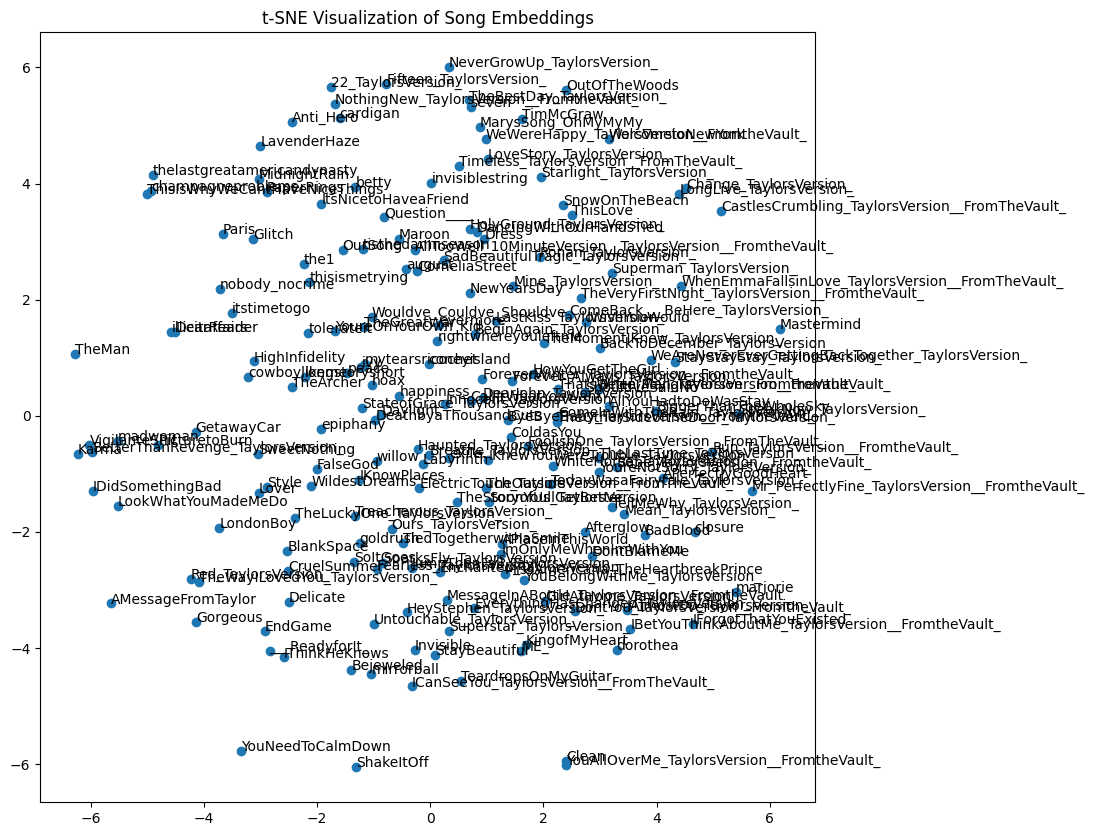

In [34]:
import matplotlib.pyplot as plt

# Assuming you have song names in a 'song_names' list
x = reduced_embeddings[:, 0]
y = reduced_embeddings[:, 1]

plt.figure(figsize=(10, 10))
plt.scatter(x, y)

song_names = df['songTitle'].tolist()
for i, song_name in enumerate(song_names):
    plt.annotate(song_name, (x[i], y[i]))

plt.title('t-SNE Visualization of Song Embeddings')
plt.show()


In [16]:
pip install plotly


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


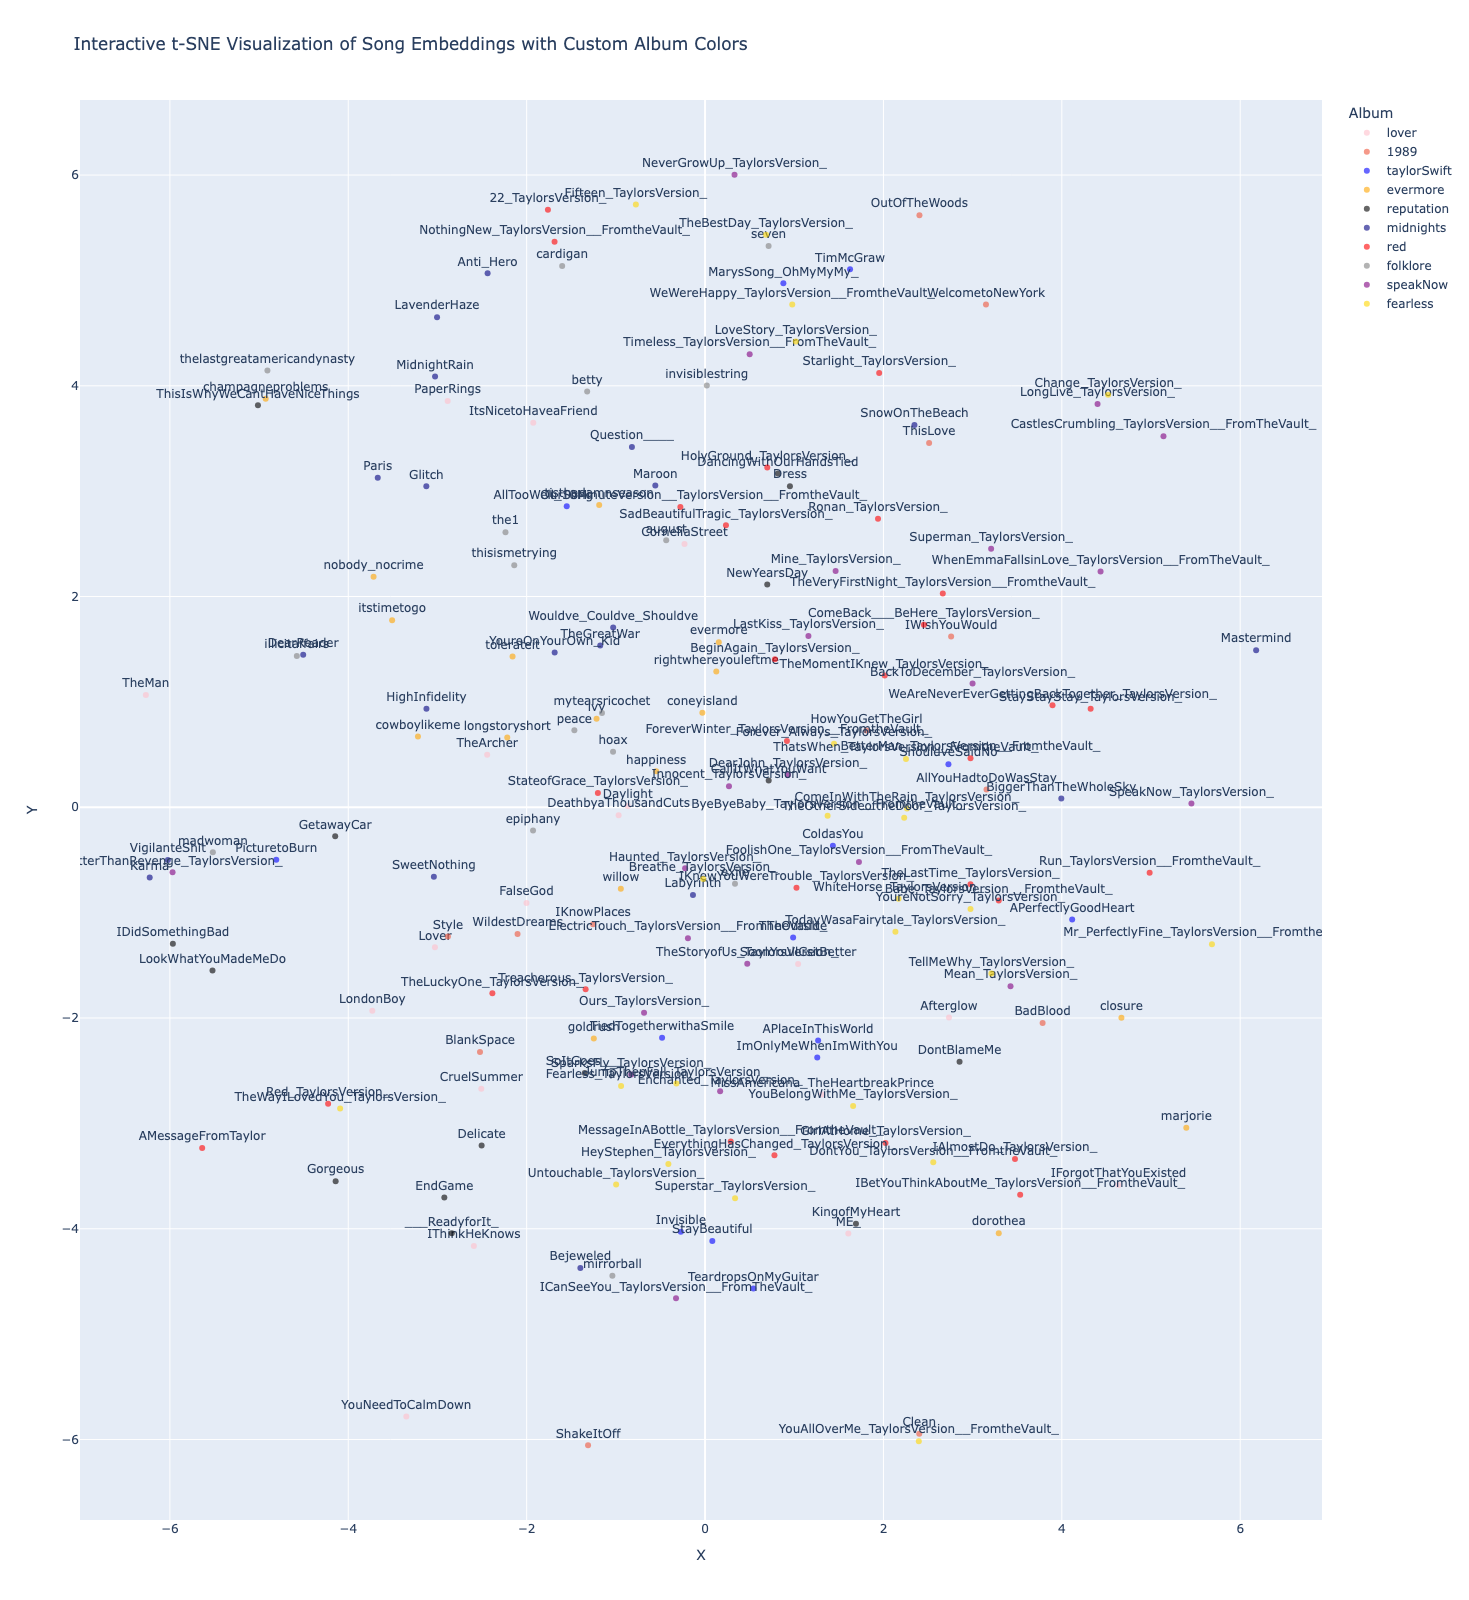

In [35]:
import plotly.express as px
import pandas as pd

# Define a dictionary to map albums to colors


album_names= df['album'].tolist()

# Create a DataFrame with album names
data = pd.DataFrame({
   'X': reduced_embeddings[:, 0],
   'Y': reduced_embeddings[:, 1],
   'Song Names': song_names,
   'Album': album_names  # Assuming you have album names
    
})

# Use the 'Album' column to map to colors from the dictionary
#data['Color'] = data['Album'].apply(lambda x: color_discrete_map.get(x.lower(), 'gray'))

# Create an interactive scatter plot with custom album colors
fig = px.scatter(
    data,
    x='X',
    y='Y',
    text='Song Names',
    color='Album',  # Use the 'Color' column for color-coding
    title='Interactive t-SNE Visualization of Song Embeddings with Custom Album Colors',
    color_discrete_map = {
        'taylorSwift': 'blue',
        'fearless': 'gold',
        'speakNow': 'purple',
        'red': 'red',
        '1989': 'light blue',
        'reputation': 'black',
        'lover': 'pink',
        'folklore': 'gray',
        'evermore': 'orange',
        'midnights': 'navy'
    }
)

# Customize the appearance of the plot
fig.update_traces(textposition='top center', marker=dict(size=6, opacity=0.6))

# Set the plot size
fig.update_layout(width=1600, height=1600)  # Adjust the width and height as needed

# Show the plot
fig.show()

